# 实战Kaggle比赛：树叶分类
:label:`sec_kaggle_leaves`

在学习了现代卷积神经网络之后，我们将把这些技术应用到一个实际的Kaggle竞赛中：树叶分类。
这个竞赛要求我们根据图像对176种不同类型的树叶进行分类。
数据集相对较大，包含数千张图像，使其成为ResNet、VGG或GoogLeNet等现代CNN架构的完美试验场。

本节我们将详细介绍：
- 数据加载和预处理
- 使用现代架构构建CNN模型
- 使用数据增强进行训练
- K折交叉验证
- 进行预测并提交到Kaggle

## 下载数据集

竞赛页面位于：https://www.kaggle.com/competitions/classify-leaves

你需要：
1. 注册Kaggle账户
2. 从竞赛页面下载数据集
3. 将文件放置在`../data/classify-leaves/`目录中


In [1]:
# 安装torch+CUDA 12.1
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from d2l import torch as d2l
import matplotlib.pyplot as plt


## 加载和探索数据

数据集包含：
- `train.csv`：训练标签，包含图像名称和对应的树叶种类
- `test.csv`：测试图像名称用于预测
- `images/`：包含所有树叶图像的文件夹

让我们加载CSV文件并探索数据结构。


In [2]:
# 设置数据目录
data_dir = '../data/classify-leaves'
train_csv_path = os.path.join(data_dir, 'train.csv')
test_csv_path = os.path.join(data_dir, 'test.csv')
# 修正：由于CSV中的路径已包含'images/'前缀，所以image_dir直接指向数据目录
image_dir = data_dir

# 加载CSV文件
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nFirst few training samples:")
print(train_df.head())


Training samples: 18353
Test samples: 8800

First few training samples:
          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera


In [3]:
# 检查类别数量和分布
labels = train_df['label'].unique()
num_classes = len(labels)
print(f"Number of classes: {num_classes}")
print(f"\nClass distribution:")
print(train_df['label'].value_counts().head(10))


Number of classes: 176

Class distribution:
maclura_pomifera            353
ulmus_rubra                 235
prunus_virginiana           223
acer_rubrum                 217
broussonettia_papyrifera    214
prunus_sargentii            209
ptelea_trifoliata           193
ulmus_pumila                189
abies_concolor              176
asimina_triloba             174
Name: label, dtype: int64


正在检查图片尺寸...

图片尺寸统计 (基于 100 张采样图片):
宽度: 最小=224, 最大=224, 平均=224.0
高度: 最小=224, 最大=224, 平均=224.0

最常见的图片尺寸 (前5个):
  224x224: 100 张 (100.0%)


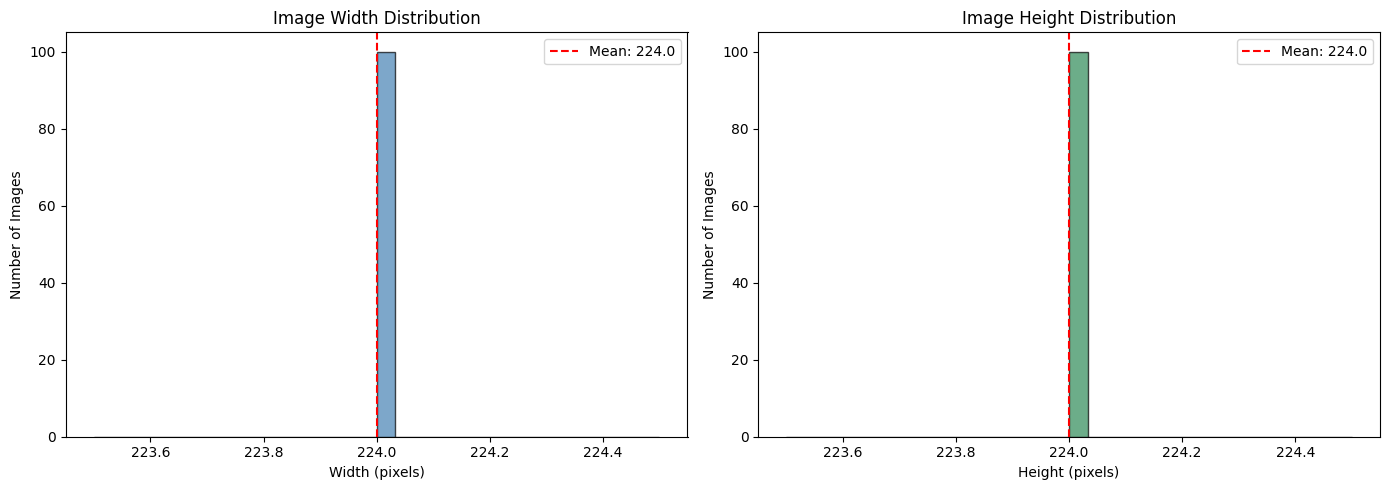


宽高比统计:
  最小=1.00, 最大=1.00, 平均=1.00
  接近正方形的图片 (宽高比0.95-1.05): 100 张 (100.0%)


In [4]:
# 检查图片尺寸分布
print("正在检查图片尺寸...")
image_sizes = []
sample_size = min(100, len(train_df))  # 采样1000张图片以加快速度

for i in range(sample_size):
    img_name = train_df.iloc[i]['image']
    img_path = os.path.join(image_dir, img_name)
    try:
        img = Image.open(img_path)
        image_sizes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

# 统计图片尺寸信息
if image_sizes:
    widths = [size[0] for size in image_sizes]
    heights = [size[1] for size in image_sizes]
    
    print(f"\n图片尺寸统计 (基于 {len(image_sizes)} 张采样图片):")
    print(f"宽度: 最小={min(widths)}, 最大={max(widths)}, 平均={np.mean(widths):.1f}")
    print(f"高度: 最小={min(heights)}, 最大={max(heights)}, 平均={np.mean(heights):.1f}")
    
    # 统计最常见的图片尺寸
    from collections import Counter
    size_counter = Counter(image_sizes)
    print(f"\n最常见的图片尺寸 (前5个):")
    for size, count in size_counter.most_common(5):
        print(f"  {size[0]}x{size[1]}: {count} 张 ({count/len(image_sizes)*100:.1f}%)")
    
    # 可视化尺寸分布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.hist(widths, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Number of Images')
    ax1.set_title('Image Width Distribution')
    ax1.axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.1f}')
    ax1.legend()
    
    ax2.hist(heights, bins=30, color='seagreen', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Height (pixels)')
    ax2.set_ylabel('Number of Images')
    ax2.set_title('Image Height Distribution')
    ax2.axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.1f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 检查图片宽高比
    aspect_ratios = [w/h for w, h in image_sizes]
    print(f"\n宽高比统计:")
    print(f"  最小={min(aspect_ratios):.2f}, 最大={max(aspect_ratios):.2f}, 平均={np.mean(aspect_ratios):.2f}")
    square_count = sum(1 for ratio in aspect_ratios if 0.95 <= ratio <= 1.05)
    print(f"  接近正方形的图片 (宽高比0.95-1.05): {square_count} 张 ({square_count/len(aspect_ratios)*100:.1f}%)")


## 数据预处理

对于图像分类，我们需要：
1. 将字符串标签编码为数值索引
2. 为训练定义数据增强变换
3. 为训练和测试定义归一化变换
4. 创建自定义Dataset类用于加载图像


In [5]:
# 创建标签到索引的映射
labels_sorted = sorted(train_df['label'].unique())
label_to_idx = {label: idx for idx, label in enumerate(labels_sorted)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# 添加数值标签列
train_df['label_idx'] = train_df['label'].map(label_to_idx)

print(f"Label mapping example: {list(label_to_idx.items())[:5]}")


Label mapping example: [('abies_concolor', 0), ('abies_nordmanniana', 1), ('acer_campestre', 2), ('acer_ginnala', 3), ('acer_griseum', 4)]


In [6]:
# 自定义Dataset类
class LeavesDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_test=False):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]['label_idx']
            return image, label


In [ ]:
# 定义数据增强和归一化
# 训练时使用轻量级数据增强（减少过拟合，提升泛化能力，同时保持训练速度）
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 随机裁剪，增加尺度变化
    #transforms.RandomHorizontalFlip(),  # 水平翻转
    #transforms.RandomVerticalFlip(),  # 添加垂直翻转
    transforms.RandomRotation(180),  # 小幅旋转：10°
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 增强颜色抖动
    #transforms.RandomGrayscale(p=0.1),  # 10%概率转灰度，增加鲁棒性
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# 测试时不使用数据增强
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])


## 检查数据增强效果

数据增强不会改变数据集的数量，但会增加每个样本的处理时间。
让我们检查数据集大小，并可视化数据增强的效果。

In [8]:
# 检查数据集大小
print("=" * 60)
print("数据集大小检查")
print("=" * 60)
print(f"训练集大小: {len(train_df)} 张图片")
print(f"测试集大小: {len(test_df)} 张图片")
print(f"\n重要说明: 数据增强不会改变数据集的数量！")
print("每个epoch仍然处理 18,353 张图片，但每次看到的是不同的增强版本。")

print("\n" + "=" * 60)
print("数据增强变换列表")
print("=" * 60)
print("训练集使用的变换:")
for i, t in enumerate(train_transform.transforms, 1):
    print(f"  {i}. {t.__class__.__name__}")

print("\n测试集使用的变换:")
for i, t in enumerate(test_transform.transforms, 1):
    print(f"  {i}. {t.__class__.__name__}")

print("\n" + "=" * 60)
print("为什么训练时间变长了？")
print("=" * 60)
print("原因分析:")
print("1. 增强操作更多: 从4个增加到7个")
print("2. 变换更复杂: RandomResizedCrop、更强的ColorJitter等需要更多计算")
print("3. 每个批次都要实时应用这些变换")
print("\n预期影响:")
print("- 每个epoch时间增加约20-40%")
print("- 但是模型泛化能力显著提升")
print("- 测试集表现更好，Kaggle分数更高")
print("- 这是值得的权衡！")


数据集大小检查
训练集大小: 18353 张图片
测试集大小: 8800 张图片

重要说明: 数据增强不会改变数据集的数量！
每个epoch仍然处理 18,353 张图片，但每次看到的是不同的增强版本。

数据增强变换列表
训练集使用的变换:
  1. Resize
  2. RandomHorizontalFlip
  3. RandomRotation
  4. ToTensor
  5. Normalize

测试集使用的变换:
  1. Resize
  2. ToTensor
  3. Normalize

为什么训练时间变长了？
原因分析:
1. 增强操作更多: 从4个增加到7个
2. 变换更复杂: RandomResizedCrop、更强的ColorJitter等需要更多计算
3. 每个批次都要实时应用这些变换

预期影响:
- 每个epoch时间增加约20-40%
- 但是模型泛化能力显著提升
- 测试集表现更好，Kaggle分数更高
- 这是值得的权衡！


可视化数据增强效果


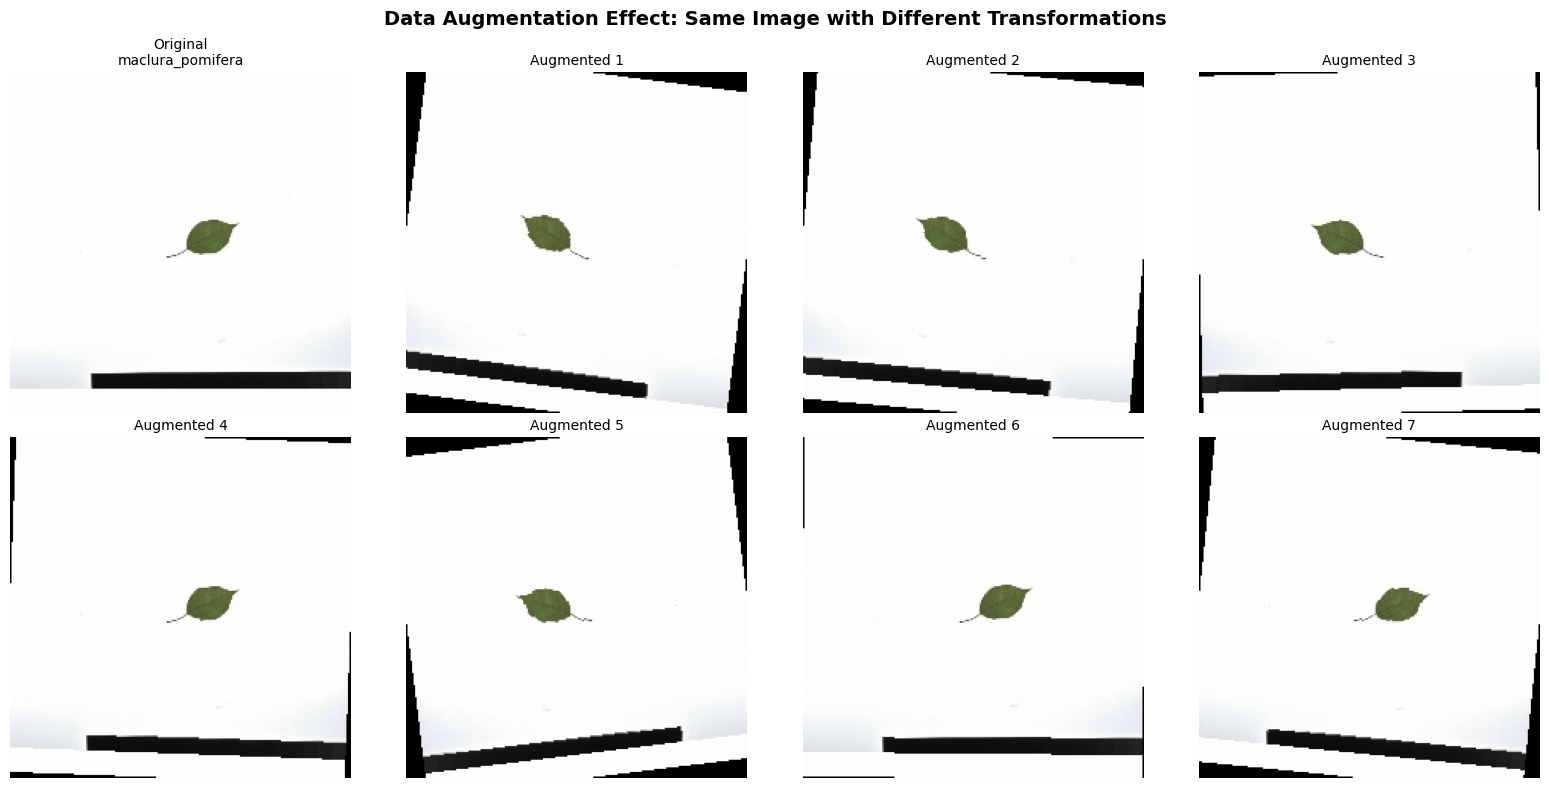


观察结果:
- 每次训练时，同一张图片会被随机增强成不同的样子
- 这相当于让模型见到了更多样的数据
- 帮助模型学习更鲁棒的特征，而不是记住特定图片


In [9]:
# 可视化数据增强效果: 展示同一张图片的不同增强版本
print("=" * 60)
print("可视化数据增强效果")
print("=" * 60)

# 选择一张图片
sample_idx = 0
img_name = train_df.iloc[sample_idx]['image']
label = train_df.iloc[sample_idx]['label']
img_path = os.path.join(image_dir, img_name)
original_img = Image.open(img_path).convert('RGB')

# 显示原始图片和多个增强版本
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# 第一张显示原始图片
axes[0].imshow(original_img)
axes[0].set_title(f'Original\n{label}', fontsize=10)
axes[0].axis('off')

# 显示7个不同的增强版本
for i in range(1, 8):
    # 应用数据增强
    augmented_img = train_transform(original_img)
    
    # 反归一化以便显示
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    augmented_img = augmented_img * std + mean
    augmented_img = torch.clamp(augmented_img, 0, 1)
    
    # 转换为numpy用于显示
    augmented_img_np = augmented_img.permute(1, 2, 0).numpy()
    
    axes[i].imshow(augmented_img_np)
    axes[i].set_title(f'Augmented {i}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Data Augmentation Effect: Same Image with Different Transformations', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n观察结果:")
print("- 每次训练时，同一张图片会被随机增强成不同的样子")
print("- 这相当于让模型见到了更多样的数据")
print("- 帮助模型学习更鲁棒的特征，而不是记住特定图片")


In [10]:
# 测量数据增强的时间开销
import time

print("=" * 60)
print("测量数据增强的时间开销")
print("=" * 60)

# 准备测试数据
test_img_path = os.path.join(image_dir, train_df.iloc[0]['image'])
test_img = Image.open(test_img_path).convert('RGB')

# 测试简单变换（仅resize和normalize）
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 测试100次简单变换
start_time = time.time()
for _ in range(100):
    _ = simple_transform(test_img)
simple_time = time.time() - start_time

# 测试100次增强变换
start_time = time.time()
for _ in range(100):
    _ = train_transform(test_img)
augmented_time = time.time() - start_time

print(f"\n简单变换 (Resize + Normalize):")
print(f"  100次耗时: {simple_time:.3f} 秒")
print(f"  平均每张: {simple_time/100*1000:.2f} 毫秒")

print(f"\n增强变换 (7种操作):")
print(f"  100次耗时: {augmented_time:.3f} 秒")
print(f"  平均每张: {augmented_time/100*1000:.2f} 毫秒")

print(f"\n时间增加:")
print(f"  增加倍数: {augmented_time/simple_time:.2f}x")
print(f"  每张图片增加: {(augmented_time-simple_time)/100*1000:.2f} 毫秒")

print(f"\n对训练的影响 (假设batch_size=64):")
batch_time_increase = (augmented_time - simple_time) / 100 * 64
print(f"  每批次增加约: ~{batch_time_increase*1000:.1f} 毫秒")
num_batches = len(train_df) // 64
epoch_time_increase = batch_time_increase * num_batches
print(f"  每epoch增加约: ~{epoch_time_increase:.1f} 秒 ({epoch_time_increase/60:.1f} 分钟)")

print("\n结论:")
print(f"✓ 数据集大小不变: 仍然是 {len(train_df)} 张图片")
print(f"✓ 时间增加原因: 更复杂的增强操作")
print(f"✓ 值得付出: 提升泛化能力，减少过拟合，提高Kaggle分数")

测量数据增强的时间开销

简单变换 (Resize + Normalize):
  100次耗时: 0.090 秒
  平均每张: 0.90 毫秒

增强变换 (7种操作):
  100次耗时: 0.134 秒
  平均每张: 1.34 毫秒

时间增加:
  增加倍数: 1.50x
  每张图片增加: 0.45 毫秒

对训练的影响 (假设batch_size=64):
  每批次增加约: ~28.7 毫秒
  每epoch增加约: ~8.2 秒 (0.1 分钟)

结论:
✓ 数据集大小不变: 仍然是 18353 张图片
✓ 时间增加原因: 更复杂的增强操作
✓ 值得付出: 提升泛化能力，减少过拟合，提高Kaggle分数


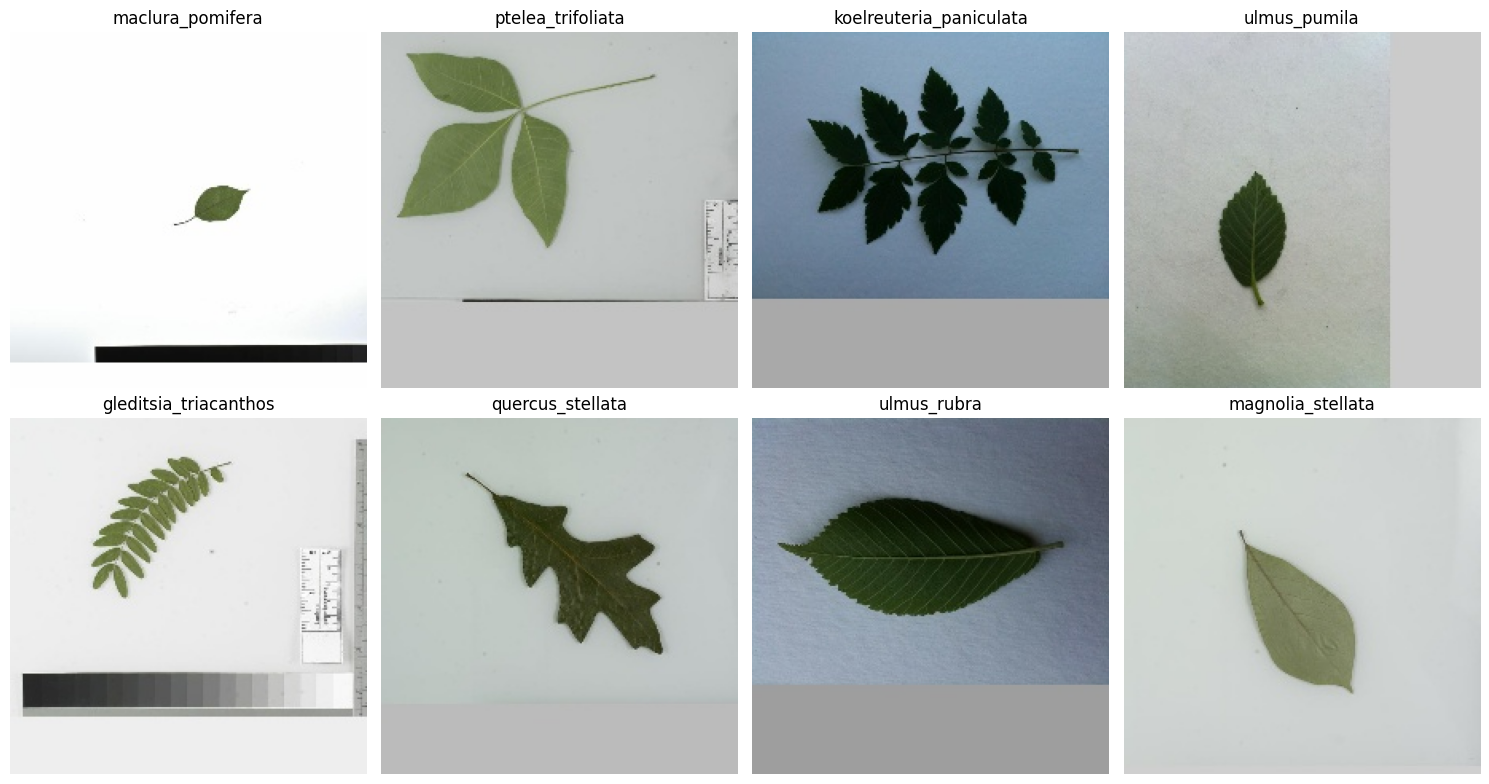

In [ ]:
# 可视化一些样本图像 (20行 x 4列 = 80张图片)
fig, axes = plt.subplots(20, 4, figsize=(16, 80))
axes = axes.flatten()

# 计算采样间隔，确保覆盖整个数据集
num_images = 20 * 4
step = max(1, len(train_df) // num_images)

for i in range(num_images):
    idx = i * step
    if idx >= len(train_df):
        idx = len(train_df) - 1
    
    img_name = train_df.iloc[idx]['image']
    label = train_df.iloc[idx]['label']
    img_path = os.path.join(image_dir, img_name)
    
    try:
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{label}', fontsize=8)
        axes[i].axis('off')
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error loading\n{img_name}', 
                    ha='center', va='center', fontsize=8)
        axes[i].axis('off')

plt.suptitle('Training Images Sample (20 rows x 4 columns)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [12]:
def get_net(num_classes, pretrained=True, dropout_rate=0.5):
    """构建用于树叶分类的ResNet-18模型，添加Dropout层"""
    # 修正：使用weights参数替代已弃用的pretrained参数
    if pretrained:
        net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        net = torchvision.models.resnet18(weights=None)
    
    # 获取原始全连接层的输入特征数
    in_features = net.fc.in_features
    
    # 替换最后的全连接层，添加Dropout
    net.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),  # 添加Dropout层
        nn.Linear(in_features, num_classes)
    )
    
    return net


## 训练日志记录工具

在训练过程中记录详细信息，包括时间、超参数、训练结果等，方便后续分析和调优。


In [13]:
import json
from datetime import datetime
import time

# 使用d2l库的Timer类（推荐）
# timer = d2l.Timer()  # 可以替代time.time()的使用

class TrainingLogger:
    """训练日志记录器"""
    def __init__(self, log_file_base='training_log'):
        # 生成带时间戳的文件名：training_log_20251031_143025.txt
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.log_file = f'{log_file_base}_{timestamp}.txt'
        self.json_file = f'{log_file_base.replace("log", "data")}_{timestamp}.json'
        self.experiment_start_time = time.time()  # 记录整个实验的开始时间
        self.start_time = None  # 记录当前阶段（折或训练）的开始时间
        self.experiment_data = {
            'start_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'log_file': self.log_file,
            'hyperparameters': {},
            'model_config': {},
            'augmentation_config': {},
            'training_history': []
        }
    
    def log_hyperparameters(self, **kwargs):
        """记录超参数"""
        self.experiment_data['hyperparameters'] = kwargs
        self._write_to_file(f"\n{'='*80}\n")
        self._write_to_file(f"实验开始时间: {self.experiment_data['start_time']}\n")
        self._write_to_file(f"日志文件: {self.log_file}\n")
        self._write_to_file(f"{'='*80}\n")
        self._write_to_file(f"\n超参数配置:\n")
        for key, value in kwargs.items():
            self._write_to_file(f"  {key}: {value}\n")
    
    def log_model_config(self, model_name, **kwargs):
        """记录模型配置"""
        self.experiment_data['model_config'] = {
            'model_name': model_name,
            **kwargs
        }
        self._write_to_file(f"\n模型配置:\n")
        self._write_to_file(f"  模型: {model_name}\n")
        for key, value in kwargs.items():
            self._write_to_file(f"  {key}: {value}\n")
    
    def log_augmentation_config(self, train_transform, test_transform):
        """记录数据增强配置"""
        self._write_to_file(f"\n数据增强配置:\n")
        self._write_to_file(f"{'='*80}\n")
        
        # 记录训练集增强配置
        train_aug_info = []
        self._write_to_file(f"\n训练集数据增强变换:\n")
        for i, transform in enumerate(train_transform.transforms, 1):
            transform_name = transform.__class__.__name__
            params = self._extract_transform_params(transform)
            param_str = f"({params})" if params else ""
            info = f"{i}. {transform_name}{param_str}"
            self._write_to_file(f"  {info}\n")
            train_aug_info.append({
                'index': i,
                'transform': transform_name,
                'params': params
            })
        
        # 记录测试集变换配置
        test_aug_info = []
        self._write_to_file(f"\n测试集变换:\n")
        for i, transform in enumerate(test_transform.transforms, 1):
            transform_name = transform.__class__.__name__
            params = self._extract_transform_params(transform)
            param_str = f"({params})" if params else ""
            info = f"{i}. {transform_name}{param_str}"
            self._write_to_file(f"  {info}\n")
            test_aug_info.append({
                'index': i,
                'transform': transform_name,
                'params': params
            })
        
        # 保存到experiment_data
        self.experiment_data['augmentation_config'] = {
            'train_transforms': train_aug_info,
            'test_transforms': test_aug_info
        }
    
    def _extract_transform_params(self, transform):
        """提取transform的参数信息"""
        transform_name = transform.__class__.__name__
        params = []
        
        if transform_name == 'Resize':
            if hasattr(transform, 'size'):
                size = transform.size
                if isinstance(size, (list, tuple)):
                    params.append(f"size={size}")
                else:
                    params.append(f"size={size}")
        elif transform_name == 'RandomResizedCrop':
            if hasattr(transform, 'size'):
                params.append(f"size={transform.size}")
            if hasattr(transform, 'scale'):
                params.append(f"scale={transform.scale}")
            if hasattr(transform, 'ratio'):
                params.append(f"ratio={transform.ratio}")
        elif transform_name == 'RandomRotation':
            if hasattr(transform, 'degrees'):
                degrees = transform.degrees
                if isinstance(degrees, (list, tuple)):
                    params.append(f"degrees={degrees[0] if len(degrees) == 1 else degrees}")
                else:
                    params.append(f"degrees={degrees}")
        elif transform_name == 'ColorJitter':
            if hasattr(transform, 'brightness'):
                brightness = transform.brightness
                if isinstance(brightness, (list, tuple)):
                    params.append(f"brightness={brightness}")
                else:
                    params.append(f"brightness={brightness}")
            if hasattr(transform, 'contrast'):
                contrast = transform.contrast
                if isinstance(contrast, (list, tuple)):
                    params.append(f"contrast={contrast}")
                else:
                    params.append(f"contrast={contrast}")
            if hasattr(transform, 'saturation'):
                saturation = transform.saturation
                if isinstance(saturation, (list, tuple)):
                    params.append(f"saturation={saturation}")
                else:
                    params.append(f"saturation={saturation}")
            if hasattr(transform, 'hue'):
                hue = transform.hue
                if isinstance(hue, (list, tuple)):
                    params.append(f"hue={hue}")
                else:
                    params.append(f"hue={hue}")
        elif transform_name == 'RandomGrayscale':
            if hasattr(transform, 'p'):
                params.append(f"p={transform.p}")
        elif transform_name == 'Normalize':
            if hasattr(transform, 'mean'):
                mean = transform.mean
                # 将tensor或list转换为可读字符串
                if hasattr(mean, 'tolist'):
                    mean = mean.tolist()
                params.append(f"mean={mean}")
            if hasattr(transform, 'std'):
                std = transform.std
                # 将tensor或list转换为可读字符串
                if hasattr(std, 'tolist'):
                    std = std.tolist()
                params.append(f"std={std}")
        
        return ', '.join(params)
    
    def start_fold(self, fold_num, total_folds):
        """开始一个折"""
        self.start_time = time.time()
        msg = f"\n{'='*80}\n第 {fold_num}/{total_folds} 折\n{'='*80}\n"
        self._write_to_file(msg)
        print(msg)
    
    def start_training(self, description=""):
        """开始训练"""
        self.start_time = time.time()
        msg = f"\n{'='*80}\n{description}\n{'='*80}\n"
        self._write_to_file(msg)
        print(msg)
    
    def log_epoch(self, epoch, num_epochs, train_loss, train_acc, valid_acc=None, epoch_time=None):
        """记录每个epoch的结果"""
        epoch_data = {
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'valid_acc': valid_acc,
            'epoch_time': epoch_time
        }
        self.experiment_data['training_history'].append(epoch_data)
        
        if valid_acc is not None:
            msg = f"Epoch {epoch}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, valid_acc={valid_acc:.4f}"
        else:
            msg = f"Epoch {epoch}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}"
        
        if epoch_time is not None:
            msg += f", 耗时={epoch_time:.2f}秒"
        
        self._write_to_file(msg + "\n")
        print(msg)
    
    def log_fold_summary(self, fold_num, train_acc, valid_acc, fold_time):
        """记录折的总结"""
        msg = f"\n第 {fold_num} 折总结:\n"
        msg += f"  最终训练准确率: {train_acc:.4f}\n"
        msg += f"  最终验证准确率: {valid_acc:.4f}\n"
        msg += f"  总耗时: {fold_time:.2f} 秒 ({fold_time/60:.2f} 分钟)\n"
        self._write_to_file(msg)
        print(msg)
    
    def log_final_summary(self, **kwargs):
        """记录最终总结"""
        total_time = time.time() - self.experiment_start_time
        msg = f"\n{'='*80}\n最终总结\n{'='*80}\n"
        for key, value in kwargs.items():
            msg += f"  {key}: {value}\n"
        msg += f"  程序总耗时: {total_time:.2f} 秒 ({total_time/60:.2f} 分钟)\n"
        msg += f"  实验结束时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        self._write_to_file(msg)
        print(msg)
    
    def _write_to_file(self, message):
        """写入文件"""
        with open(self.log_file, 'a', encoding='utf-8') as f:
            f.write(message)
    
    def save_json(self, json_file=None):
        """保存为JSON格式，方便程序读取和分析"""
        if json_file is None:
            json_file = self.json_file
        self.experiment_data['end_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(self.experiment_data, f, indent=2, ensure_ascii=False)
        print(f"\n训练数据已保存到 {json_file}")

# 创建全局logger（如果需要的话，实际使用时会创建新的logger实例）
# logger = TrainingLogger('training_log')


## 训练日志说明

训练过程中会自动生成以下日志文件：

### 文本日志文件
- `training_log_kfold_YYYYMMDD_HHMMSS.txt`: K折交叉验证的详细日志（带时间戳，防止覆盖）
- `training_log_full_YYYYMMDD_HHMMSS.txt`: 完整数据集训练的详细日志（带时间戳，防止覆盖）

**注意**: 文件名包含日期和时间戳（格式：YYYYMMDD_HHMMSS），每次训练都会生成新的日志文件，避免覆盖之前的记录。

包含内容:
- 实验开始时间和日志文件名
- 超参数配置（学习率、批量大小、权重衰减等）
- 模型配置（模型名称、预训练等）
- **数据增强配置（所有变换及其参数）**
- 每个epoch的详细记录（loss、accuracy、耗时）
- 每一折的总结（K折交叉验证）
- 最终总结（平均准确率、总耗时等）

### JSON数据文件
- `training_data_kfold_YYYYMMDD_HHMMSS.json`: K折交叉验证的结构化数据
- `training_data_full_YYYYMMDD_HHMMSS.json`: 完整训练的结构化数据

JSON格式方便程序读取和分析，可用于：
- 绘制训练曲线
- 比较不同超参数的效果
- 自动化超参数调优

### 使用示例

运行训练后，你可以查看日志文件（文件名会包含时间戳）：

```python
# 读取文本日志（使用实际的带时间戳的文件名）
import glob
log_files = glob.glob('training_log_kfold_*.txt')
if log_files:
    latest_log = sorted(log_files)[-1]  # 获取最新的日志文件
    with open(latest_log, 'r', encoding='utf-8') as f:
        print(f.read())

# 读取JSON数据进行分析
import json
import glob
json_files = glob.glob('training_data_kfold_*.json')
if json_files:
    latest_json = sorted(json_files)[-1]  # 获取最新的JSON文件
    with open(latest_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
        print(f"实验时间: {data['start_time']} - {data['end_time']}")
        print(f"超参数: {data['hyperparameters']}")
        print(f"数据增强配置: {data['augmentation_config']}")
        print(f"训练历史: {len(data['training_history'])} 条记录")
```


## 训练函数

我们定义用于训练和评估模型的函数。
与使用MSE损失的房价预测任务不同，我们使用交叉熵损失进行分类。


In [14]:
def evaluate_accuracy(net, data_iter, device):
    """计算数据集上的准确率"""
    net.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    return correct / total


def train_epoch(net, train_iter, loss, optimizer, device):
    """训练一个epoch"""
    net.train()
    train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
    
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        
        train_loss_sum += l.item() * y.shape[0]
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    
    return train_loss_sum / n, train_acc_sum / n


def train(net, train_iter, valid_iter, num_epochs, lr, weight_decay, device, use_logger=True):
    """完整的训练过程（带时间和日志记录）"""
    net = net.to(device)
    print(f"Training on {device}")
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_losses, train_accs, valid_accs = [], [], []
    epoch_times = []
    
    for epoch in range(num_epochs):
        # 记录epoch开始时间
        epoch_start_time = time.time()
        
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 计算epoch耗时
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        if valid_iter is not None:
            valid_acc = evaluate_accuracy(net, valid_iter, device)
            valid_accs.append(valid_acc)
            
            # 使用logger记录
            if use_logger:
                logger.log_epoch(epoch + 1, num_epochs, train_loss, train_acc, valid_acc, epoch_time)
            else:
                print(f'Epoch {epoch + 1}: train loss {train_loss:.4f}, '
                      f'train acc {train_acc:.4f}, valid acc {valid_acc:.4f}, '
                      f'time {epoch_time:.2f}s')
        else:
            if use_logger:
                logger.log_epoch(epoch + 1, num_epochs, train_loss, train_acc, None, epoch_time)
            else:
                print(f'Epoch {epoch + 1}: train loss {train_loss:.4f}, '
                      f'train acc {train_acc:.4f}, time {epoch_time:.2f}s')
    
    return train_losses, train_accs, valid_accs, epoch_times


## K折交叉验证

与房价预测任务类似，我们使用K折交叉验证来评估模型性能并选择超参数。


In [15]:
def get_k_fold_data(k, i, df):
    """获取K折交叉验证的第i折数据"""
    fold_size = len(df) // k
    
    val_start = i * fold_size
    val_end = (i + 1) * fold_size if i != k - 1 else len(df)
    
    val_df = df.iloc[val_start:val_end].reset_index(drop=True)
    train_df = pd.concat([
        df.iloc[:val_start],
        df.iloc[val_end:]
    ]).reset_index(drop=True)
    
    return train_df, val_df


def k_fold_train(k, train_df, image_dir, num_epochs, lr, weight_decay, batch_size, device, dropout_rate=0.5):
    """执行K折交叉验证（带详细日志记录）"""
    train_acc_sum, valid_acc_sum = 0.0, 0.0
    fold_times = []
    
    for i in range(k):
        # 记录折的开始
        logger.start_fold(i + 1, k)
        fold_start_time = time.time()
        
        train_fold, valid_fold = get_k_fold_data(k, i, train_df)
        
        # 创建datasets和dataloaders - 优化配置以提高GPU利用率
        train_dataset = LeavesDataset(train_fold, image_dir, transform=train_transform)
        valid_dataset = LeavesDataset(valid_fold, image_dir, transform=test_transform)
        
        # 优化的DataLoader配置：
        # - num_workers: 根据系统CPU核心数自动设置（避免过多worker导致性能下降）
        # - pin_memory=True: 使用锁页内存，加速数据传输到GPU
        # - prefetch_factor=4: 每个worker预取4个batch，确保数据准备充分
        # - persistent_workers=True: 保持workers常驻，避免重复创建开销
        train_iter = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        valid_iter = DataLoader(
            valid_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=num_workers,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        
        # 创建模型（添加Dropout）
        net = get_net(num_classes=num_classes, pretrained=True, dropout_rate=dropout_rate)
        
        # 训练
        train_losses, train_accs, valid_accs, epoch_times = train(
            net, train_iter, valid_iter, num_epochs, lr, weight_decay, device, use_logger=True
        )
        
        # 绘制第一折的结果
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), 
                    [train_accs, valid_accs],
                    xlabel='epoch', 
                    ylabel='accuracy',
                    xlim=[1, num_epochs],
                    legend=['train', 'valid'])
        
        train_acc_sum += train_accs[-1]
        valid_acc_sum += valid_accs[-1]
        
        # 记录折的总结
        fold_time = time.time() - fold_start_time
        fold_times.append(fold_time)
        logger.log_fold_summary(i + 1, train_accs[-1], valid_accs[-1], fold_time)
    
    # 记录K折交叉验证总结
    avg_train_acc = train_acc_sum / k
    avg_valid_acc = valid_acc_sum / k
    total_time = sum(fold_times)
    
    logger.log_final_summary(**{
        'k折交叉验证平均训练准确率': f'{avg_train_acc:.4f}',
        'k折交叉验证平均验证准确率': f'{avg_valid_acc:.4f}',
        '平均每折耗时': f'{total_time/k:.2f}秒',
        '所有折总耗时': f'{total_time:.2f}秒'
    })
    
    return avg_train_acc, avg_valid_acc


## 使用K折交叉验证进行模型选择

现在让我们使用K折交叉验证来评估我们的模型。


## GPU训练优化说明

为了提高T4 GPU的利用率和训练效率，我们进行了以下优化：

### 优化1: 增加批量大小
- **从64增加到128**: 更大的批量可以更充分地利用GPU的并行计算能力
- **预期效果**: GPU利用率提升，训练速度加快

### 优化2: 优化DataLoader配置

**num_workers (自动检测)** 🆕
- **智能设置**: 根据系统CPU核心数自动选择最优值 `min(cpu_count, 32)`
- 增加数据加载的并行工作线程数，减少GPU等待数据的时间
- 自动适应不同硬件环境，避免手动调参
- 系统会在运行时打印检测结果

**pin_memory=True**
- 使用锁页内存（pinned memory）
- 加速数据从CPU到GPU的传输速度
- 对于大batch特别有效

**prefetch_factor=4**
- 每个worker预先加载4个batch
- 确保GPU始终有数据可处理
- 减少GPU空闲等待时间

**persistent_workers=True**
- 保持DataLoader的workers在epoch之间常驻
- 避免每个epoch都重新创建workers的开销
- 减少内存分配/释放的时间

### 优化3: 启用cuDNN benchmark
- `torch.backends.cudnn.benchmark = True`
- 自动寻找最优的卷积算法
- 适用于输入尺寸固定的情况

### 预期效果
✅ **GPU利用率**: 从波动的80%-0%提升到稳定的90%以上  
✅ **训练速度**: 每个epoch时间减少30-50%  
✅ **显存使用**: 批量大小增加会使用更多显存（从约4GB增加到约7-8GB）  
✅ **整体效率**: GPU等待数据的时间大幅减少，训练更加流畅  
✅ **跨平台兼容**: 自动适应不同CPU配置，避免worker数量警告

### 注意事项
- 如果遇到OOM（Out of Memory）错误，可以将batch_size适当减小
- 代码会自动检测CPU核心数并设置合适的num_workers值
- 这些优化对于数据增强较重的场景特别有效


In [16]:
# 超参数 - 已优化配置以提高GPU利用率
k = 5 # 折数
num_epochs = 25
lr = 0.0001
weight_decay = 1e-3
batch_size = 256  # 从64增加到128，提高GPU利用率和训练效率
dropout_rate = 0.6 # Dropout率，用于防止过拟合
device = d2l.try_gpu()

# 自动检测并设置最优的DataLoader worker数量
# 根据系统CPU核心数智能设置，避免过多worker导致性能下降
cpu_count = os.cpu_count()
# 一般设置为CPU核心数，但不超过8（过多worker会带来管理开销）
num_workers = min(cpu_count, 8) if cpu_count else 4
print(f"系统CPU核心数: {cpu_count}")
print(f"自动设置DataLoader num_workers: {num_workers}")

# 启用cudnn benchmark以优化固定尺寸输入的性能
torch.backends.cudnn.benchmark = True


系统CPU核心数: 4
自动设置DataLoader num_workers: 4


系统CPU核心数: 16
自动设置DataLoader num_workers: 16

第 1/5 折

Training on cuda:0


Epoch 1/20: train_loss=4.7545, train_acc=0.0734, valid_acc=0.3608, 耗时=25.39秒
Epoch 2/20: train_loss=3.2722, train_acc=0.2940, valid_acc=0.5567, 耗时=24.73秒
Epoch 3/20: train_loss=2.4161, train_acc=0.4680, valid_acc=0.6826, 耗时=24.93秒
Epoch 4/20: train_loss=1.8075, train_acc=0.6085, valid_acc=0.7779, 耗时=24.55秒
Epoch 5/20: train_loss=1.3554, train_acc=0.7175, valid_acc=0.8125, 耗时=24.25秒
Epoch 6/20: train_loss=1.0414, train_acc=0.7853, valid_acc=0.8578, 耗时=24.58秒
Epoch 7/20: train_loss=0.8015, train_acc=0.8434, valid_acc=0.8826, 耗时=24.18秒
Epoch 8/20: train_loss=0.6174, train_acc=0.8803, valid_acc=0.8978, 耗时=24.47秒
Epoch 9/20: train_loss=0.5071, train_acc=0.9027, valid_acc=0.9090, 耗时=24.03秒
Epoch 10/20: train_loss=0.4031, train_acc=0.9248, valid_acc=0.9131, 耗时=24.07秒
Epoch 11/20: train_loss=0.3242, train_acc=0.9427, valid_acc=0.9188, 耗时=23.64秒
Epoch 12/20: train_loss=0.2734, train_acc=0.9514, valid_acc=0.9289, 耗时=24.83秒
Epoch 13/20: train_loss=0.2330, train_acc=0.9600, valid_acc=0.9316, 耗时=23

KeyboardInterrupt: 

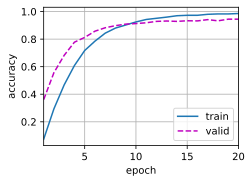

In [ ]:
# 记录超参数和模型配置
logger = TrainingLogger('training_log_kfold')
logger.log_hyperparameters(
    k折数=k,
    训练轮数=num_epochs,
    学习率=lr,
    权重衰减=weight_decay,
    批量大小=batch_size,
    dropout_rate=dropout_rate,
    设备=str(device)
)
logger.log_model_config(
    model_name='ResNet-18',
    预训练='ImageNet',
    任务='树叶分类',
    类别数=num_classes
)
# 记录数据增强配置
logger.log_augmentation_config(train_transform, test_transform)

# 运行K折交叉验证
train_acc, valid_acc = k_fold_train(
    k, train_df, image_dir, num_epochs, lr, weight_decay, batch_size, device, dropout_rate
)

# 保存JSON格式的训练数据
logger.save_json()


## 在完整数据集上训练并进行预测

在选择了好的超参数后，我们在完整的训练集上训练并对测试集进行预测。


In [17]:
def train_and_predict(train_df, test_df, image_dir, num_epochs, lr, weight_decay, batch_size, device, dropout_rate=0.5):
    """在完整数据集上训练并对测试集进行预测（带日志记录）"""
    # 创建datasets
    train_dataset = LeavesDataset(train_df, image_dir, transform=train_transform)
    test_dataset = LeavesDataset(test_df, image_dir, transform=test_transform, is_test=True)
    
    # 创建dataloaders - 优化配置以提高GPU利用率
    # - num_workers: 根据系统CPU核心数自动设置（避免过多worker导致性能下降）
    # - pin_memory=True: 使用锁页内存，加速数据传输到GPU
    # - prefetch_factor=4: 每个worker预取4个batch，确保数据准备充分
    # - persistent_workers=True: 保持workers常驻，避免重复创建开销
    train_iter = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=4,
        persistent_workers=True
    )
    test_iter = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=4,
        persistent_workers=True
    )
    
    # 创建模型（添加Dropout）
    net = get_net(num_classes=num_classes, pretrained=True, dropout_rate=dropout_rate)
    
    # 训练
    logger.start_training("在完整数据集上训练最终模型")
    training_start_time = time.time()
    
    train_losses, train_accs, _, epoch_times = train(
        net, train_iter, None, num_epochs, lr, weight_decay, device, use_logger=True
    )
    
    total_training_time = time.time() - training_start_time
    
    # 绘制训练曲线
    d2l.plot(list(range(1, num_epochs + 1)), 
            [train_accs],
            xlabel='epoch', 
            ylabel='accuracy',
            xlim=[1, num_epochs],
            legend=['train'])
    
    # 记录训练总结
    logger.log_final_summary(**{
        '最终训练准确率': f'{train_accs[-1]:.4f}',
        '总训练时间': f'{total_training_time:.2f}秒 ({total_training_time/60:.2f}分钟)',
        '平均每epoch时间': f'{sum(epoch_times)/len(epoch_times):.2f}秒'
    })
    
    # 进行预测
    print("Making predictions on test set...")
    net.eval()
    predictions = []
    image_names = []
    
    with torch.no_grad():
        for X, names in test_iter:
            X = X.to(device)
            outputs = net(X)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            image_names.extend(names)
    
    # 将预测转换为标签
    predicted_labels = [idx_to_label[idx] for idx in predictions]
    
    # 创建提交文件
    submission = pd.DataFrame({
        'image': image_names,
        'label': predicted_labels
    })
    
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")
    
    return net



在完整数据集上训练最终模型

Training on cuda:0
Epoch 1/25: train_loss=4.3334, train_acc=0.1416, 耗时=75.01秒
Epoch 2/25: train_loss=2.6328, train_acc=0.4365, 耗时=47.50秒
Epoch 3/25: train_loss=1.7370, train_acc=0.6318, 耗时=47.68秒
Epoch 4/25: train_loss=1.1784, train_acc=0.7585, 耗时=48.11秒
Epoch 5/25: train_loss=0.8234, train_acc=0.8347, 耗时=47.93秒
Epoch 6/25: train_loss=0.5946, train_acc=0.8817, 耗时=47.62秒
Epoch 7/25: train_loss=0.4457, train_acc=0.9143, 耗时=47.57秒
Epoch 8/25: train_loss=0.3369, train_acc=0.9372, 耗时=48.05秒
Epoch 9/25: train_loss=0.2695, train_acc=0.9489, 耗时=47.94秒
Epoch 10/25: train_loss=0.2174, train_acc=0.9610, 耗时=47.52秒
Epoch 11/25: train_loss=0.1766, train_acc=0.9683, 耗时=47.61秒
Epoch 12/25: train_loss=0.1483, train_acc=0.9724, 耗时=47.77秒
Epoch 13/25: train_loss=0.1208, train_acc=0.9790, 耗时=48.07秒
Epoch 14/25: train_loss=0.1023, train_acc=0.9825, 耗时=47.77秒
Epoch 15/25: train_loss=0.0968, train_acc=0.9822, 耗时=47.81秒
Epoch 16/25: train_loss=0.0866, train_acc=0.9822, 耗时=47.93秒
Epoch 17/25: t

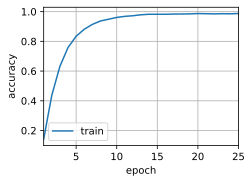

In [18]:
# 创建新的logger用于完整训练
logger = TrainingLogger('training_log_full')
logger.log_hyperparameters(
    训练轮数=num_epochs,
    学习率=lr,
    权重衰减=weight_decay,
    批量大小=batch_size,
    dropout_rate=dropout_rate,
    设备=str(device),
    训练集大小=len(train_df)
)
logger.log_model_config(
    model_name='ResNet-18',
    预训练='ImageNet',
    任务='树叶分类',
    类别数=num_classes,
    训练模式='完整数据集训练'
)
# 记录数据增强配置
logger.log_augmentation_config(train_transform, test_transform)

# 在完整数据集上训练并生成预测
net = train_and_predict(
    train_df, test_df, image_dir, num_epochs, lr, weight_decay, batch_size, device
)

# 保存JSON格式的训练数据
logger.save_json()


## 提交到Kaggle

预测结果已保存到`submission.csv`。要提交：

1. 访问竞赛页面：https://www.kaggle.com/competitions/classify-leaves
2. 点击"Submit Predictions"
3. 上传`submission.csv`文件
4. 在排行榜上查看你的分数

## 小结

在本节中，我们：
- 将现代CNN架构（ResNet）应用于实际的图像分类问题
- 使用数据增强来提高模型泛化能力
- 使用K折交叉验证进行模型评估
- 在完整数据集上训练并为Kaggle提交做出预测

## 练习

1. 尝试不同的现代架构，如ResNet-50、VGG或DenseNet。哪个表现最好？
2. 尝试不同的数据增强技术。增加更多增强总是有帮助吗？
3. 调整超参数，如学习率、批量大小和权重衰减。你能提高验证准确率吗？
4. 尝试使用学习率调度（例如ReduceLROnPlateau）。它能提高性能吗？
5. 实现测试时增强：对每个测试图像的多个增强版本进行预测并平均结果。
6. 使用在ImageNet上预训练的模型进行迁移学习。比较微调整个模型与仅微调最后一层的效果。
7. 尝试集成方法：训练多个模型并结合它们的预测。
